In [1]:
#!pip3 install --upgrade pip.
#!pip3 install --upgrade tensorflow.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\petert6\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\petert6\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\petert6\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\petert6\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub

In [2]:
'''
For this project I wanted to try and work with text data. Mostly because this kind of data would have no relation to any 
kind of numerical statistics or classification and I would really like to see just how a ML model could exactly work
with this kind of data. After doing some research, a text generation model utilizing the complex verses from 
Shakespeare seems to be a popular dataset to use for this kind of problem. So I will be using another Kaggle dataset
to try and create an RNN model that can analyze and predict the next word(s) that would appear in a sentence written in
shakesperean dialect. The framework wil lconsist of the tesnorflow package seeing as how that package can make a model 
utilizing RNN, LSTM, and GRU layers.

https://www.tensorflow.org/guide/keras/rnn

https://www.tensorflow.org/text/tutorials/text_generation

https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://github.com/AdalbertoCq/Deep-Learning-Specialization-Coursera/tree/master/Sequence%20Models/week1/Character-level%20language%20model

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://www.marktechpost.com/2021/04/01/generating-your-shakespeare-text-using-sequential-models-such-as-long-short-term-memory-lstms-gated-recurrent-units-grus-recurrent-neural-network-rnns/

https://www.kaggle.com/kutaykutlu/text-generation-guide-tensorflow-nlp-lstm

https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

https://medium.com/@annikabrundyn1/the-beginners-guide-to-recurrent-neural-networks-and-text-generation-44a70c34067f

https://www.section.io/engineering-education/text-generation-nn/

https://hub.packtpub.com/auto-generate-texts-shakespeare-writing-using-deep-recurrent-neural-networks/

https://keras.io/guides/working_with_rnns/
'''

'\nFor this project I wanted to try and work with text data. Mostly because this kind of data would have no relation to any \nkind of numerical statistics or classification and I would really like to see just how a ML model could exactly work\nwith this kind of data. After doing some research, a text generation model utilizing the complex verses from \nShakespeare seems to be a popular dataset to use for this kind of problem. So I will be using another Kaggle dataset\nto try and create an RNN model that can analyze and predict the next word(s) that would appear in a sentence written in\nshakesperean dialect. The framework wil lconsist of the tesnorflow package seeing as how that package can make a model \nutilizing RNN, LSTM, and GRU layers.\n\nhttps://www.tensorflow.org/guide/keras/rnn\n\nhttps://www.tensorflow.org/text/tutorials/text_generation\n\nhttps://www.tensorflow.org/text/tutorials/text_classification_rnn\n\nhttps://github.com/AdalbertoCq/Deep-Learning-Specialization-Coursera/

In [3]:
text = open('shakespeare.txt', 'rb').read().decode(encoding='utf-8')
print(len(text))
# The unique characters in the file
vocab = sorted(list(set(text)))
print(len(vocab))

4583798
78


In [4]:
'''
In this group of code I am building the datasets to be trained and examined in this HW. Howver, since it usually took
a really long time to try and compute even 1,000,000 words I decided to only use a small amount of the data for the 
RNN and LSTM model
'''


char_indices = {c:i for i, c in enumerate(vocab)}
indices_char = {i:c for i, c in enumerate(vocab)}



def build_data(text, Tx = 10, stride = 3):  
    X = []
    Y = []
    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx]) 
    print('number of training examples:', len(X))
    return X, Y



print("Dev data")
X_dev,Y_dev = build_data(text[:10000])
print("Training data")
X_train, Y_train = build_data(text[10000:40000])
print("Test data")
X_test, Y_test = build_data(text[40000:50000])

    


Dev data
number of training examples: 3330
Training data
number of training examples: 9997
Test data
number of training examples: 3330


In [5]:
'''
Here we vectorize all of the datasets so that the Sequential models and their layers will be able to perform
their training and evaluations
'''

def vectorization(X, Y, n_x, char_indices, Tx = 10):
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, n_x), dtype=np.bool)
    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[Y[i]]] = 1    
    return x, y 


x_train,y_train = vectorization(X_train,Y_train,len(vocab),char_indices,Tx=10)
x_test,y_test = vectorization(X_test,Y_test,len(vocab),char_indices,Tx=10)
x_dev,y_dev = vectorization(X_dev,Y_dev,len(vocab),char_indices,Tx=10)

In [6]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN
'''
This is where we make the regular RNN model. Thanks to the tensorflow framework I don't need to hardcode the entire 
structure of the model. I can make an entire RNN model from these simple lines of code for not only the regular RNN but also
LSTM, GRU, etc.

Most of the examples I saw online used one RNN layer as the starting input layer and then continued creating the 
network using Dense layers so I figured I would do the same. All of the layers up to the final output layer use the 
relu activation function, since this is still a deep learning model, and then I use a softmax activation function for the 
output layer. Once that is done I then use the 'compile' function of the Sequential model to build it for training. The 
'compile' function even has arguments to create the optimizer and loss functions so for those I use the categorical
crossentropy function to go with the output layer's softmax function while also performing the cross-entropy loss function
on the data, and I also use the 'adam' optimizer since I have used that one throughout my previous homeworks. To finish 
off on the compiling I also make sure that the metrics being evaluated throught the training is the 'accuracy'

'''


model = Sequential()
model.add(SimpleRNN(units=256, input_shape=(10,len(vocab)), activation="relu",return_sequences=True))

model.add(SimpleRNN(256))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(len(vocab), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 256)           85760     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               131328    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 78)                10062     
Total params: 276,558
Trainable params: 276,558
Non-trainable params: 0
_________________________________________________________________


In [7]:
'''
The 'fit' function is how the model is trained by using a set number of 'epochs'. 
'''

history = model.fit(x_train,y_train, epochs=30, verbose=1)

Train on 9997 samples
Epoch 1/30
9997/9997 [==============================] - 8s 828us/sample - loss: 2.9694 - accuracy: 0.2117
Epoch 2/30
9997/9997 [==============================] - 6s 609us/sample - loss: 2.4306 - accuracy: 0.3187
Epoch 3/30
9997/9997 [==============================] - 5s 508us/sample - loss: 2.2454 - accuracy: 0.3636
Epoch 4/30
9997/9997 [==============================] - 7s 697us/sample - loss: 2.1123 - accuracy: 0.3895
Epoch 5/30
9997/9997 [==============================] - 6s 556us/sample - loss: 1.9886 - accuracy: 0.4155
Epoch 6/30
9997/9997 [==============================] - 5s 530us/sample - loss: 1.8819 - accuracy: 0.4481 - loss: 1.8764 - accu
Epoch 7/30
9997/9997 [==============================] - 5s 533us/sample - loss: 1.7579 - accuracy: 0.4738
Epoch 8/30
9997/9997 [==============================] - 5s 524us/sample - loss: 1.6408 - accuracy: 0.4989 - loss: 1.6328 - accuracy: 0.49 - ETA: 0s - loss: 1.6329 - 
Epoch 9/30
9997/9997 [==========================

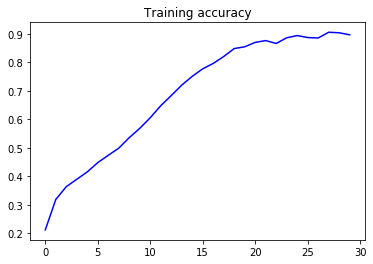

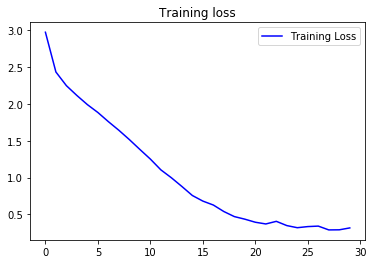

In [8]:
'''
Here is where both the training accuracy and the training loss are shown in a line graph form. As one can see, each value
metric is doing what it should with the training accuracy growing after each epoch and the training loss decreasing
after each epoch
'''

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [9]:
'''
Here the accuracy of both the validation and test sets are calculated and shown. Unfortunately both end up having a low
accuracy score. This may be due to not doing enough training in the 'fit' function or because I didn't
use the entire 'shakespeare' dataset
'''


val_eval = model.evaluate(x_dev, y_dev, verbose=0)
print('Validation loss:', val_eval[0])
print('Validation accuracy:', val_eval[1])


test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Validation loss: 5.205393154270298
Validation accuracy: 0.3174174
Test loss: 4.9510669175569
Test accuracy: 0.33483484


In [12]:
'''
Now we begin part 2 of Task 1 of the HW. In this model I will be using the LSTM structure instead of the RNN. And to make
the comparisons as fair as possible I used the exact same model structure as with the RNN model.
'''


model = Sequential()
model.add(LSTM(units=256, input_shape=(10,len(vocab)), activation="relu",return_sequences=True))
model.add(LSTM(256))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(len(vocab), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 256)           343040    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 78)                10062     
Total params: 927,822
Trainable params: 927,822
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x_train,y_train, epochs=30, verbose=1)

Train on 9997 samples
Epoch 1/30
9997/9997 [==============================] - 25s 3ms/sample - loss: 3.3028 - accuracy: 0.1467
Epoch 2/30
9997/9997 [==============================] - 24s 2ms/sample - loss: 2.9442 - accuracy: 0.2067
Epoch 3/30
9997/9997 [==============================] - 25s 3ms/sample - loss: 2.5118 - accuracy: 0.2944
Epoch 4/30
9997/9997 [==============================] - 24s 2ms/sample - loss: 2.3673 - accuracy: 0.3272
Epoch 5/30
9997/9997 [==============================] - 23s 2ms/sample - loss: 2.2646 - accuracy: 0.3460
Epoch 6/30
9997/9997 [==============================] - 23s 2ms/sample - loss: 2.1907 - accuracy: 0.3598
Epoch 7/30
9997/9997 [==============================] - 24s 2ms/sample - loss: 2.1299 - accuracy: 0.3764
Epoch 8/30
9997/9997 [==============================] - 24s 2ms/sample - loss: 2.0617 - accuracy: 0.3872
Epoch 9/30
9997/9997 [==============================] - 24s 2ms/sample - loss: 1.9883 - accuracy: 0.4121
Epoch 10/30
9997/9997 [==========

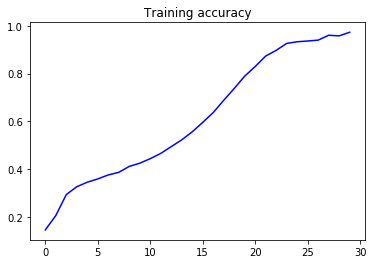

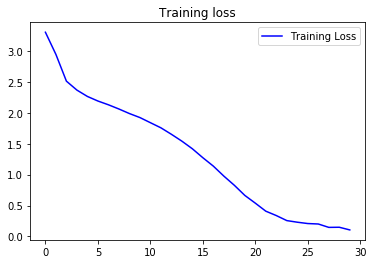

In [14]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [15]:
val_eval = model.evaluate(x_dev, y_dev, verbose=0)
print('Validation loss:', val_eval[0])
print('Validation accuracy:', val_eval[1])


test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Validation loss: 5.821508167312668
Validation accuracy: 0.34414414
Test loss: 5.694698528770928
Test accuracy: 0.35255256


In [ ]:
'''
Based on the results the LSTM model seems to perform better than the RNN model. Though that is in terms of accuracy.
The LSTM model still took longer to train than it did for the RNN model despite using the same data and method of training.
Though that may be because of my computer. As for the accuracy result, this is most likely because of LSTM's "memory"
ability, allowing it to carry information throughout the process regardless of when the information was received during
the process
'''